In [1]:
"""
Detectar la posición (centroide) de una esfera oscura sobre un fondo blanco
en una imagen estática.

Requisitos:
    pip install opencv-python-headless numpy

Uso:
    python detectar_bola.py ruta/a/imagen.jpg
"""

import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
path_img="Screenshot 2025-08-12 at 5.33.12 AM.png"

In [3]:
# 1. Cargar imagen y asegurar lectura correcta
# Read image
img = cv2.imread(path_img)
orig_h, orig_w = img.shape[:2]
if img is None:
    raise FileNotFoundError(f"No se pudo abrir la imagen: {path_img}")

In [4]:
np.shape(img)

(1168, 966, 3)

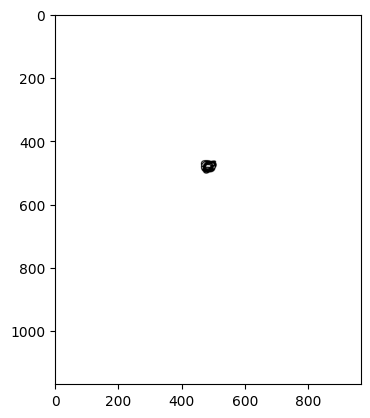

In [5]:
plt.imshow(img,cmap="gray")

In [6]:
# 2. Convertir a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

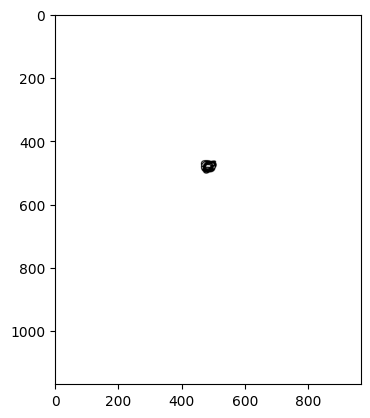

In [7]:
plt.imshow(gray,cmap="gray")

In [8]:
np.shape(gray)

(1168, 966)

In [9]:
gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]],
      shape=(1168, 966), dtype=uint8)

In [10]:
print("El máximo es",np.max(gray))
print("El mínimo es",np.min(gray))
print("El promedio es",np.mean(gray))
print("La desviación estándar es",np.std(gray))

El máximo es 255
El mínimo es 0
El promedio es 254.64523862701722
La desviación estándar es 9.333335909974636


Image size: 966 x 1168 (w x h, pixels)
Detected centroid (x, y) in pixel coordinates (origin at top-left): (484.41, 480.24)


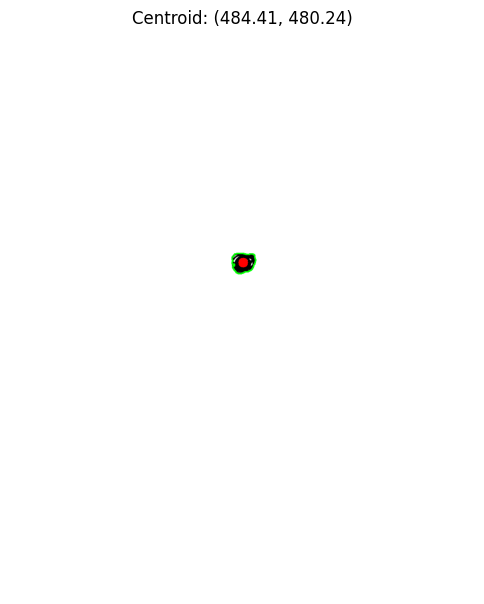

In [11]:
# Slight blur to reduce noise
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Otsu threshold: because the dot is dark on a bright background
# THRESH_BINARY_INV turns the dark dot to white on black background
_, mask = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove tiny noise (opening)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

# Find contours
cnts, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if not cnts:
    raise RuntimeError("No contours found. Try adjusting preprocessing.")

# Choose the largest contour (by area) to represent the dot
areas = [cv2.contourArea(c) for c in cnts]
largest_idx = int(np.argmax(areas))
dot_contour = cnts[largest_idx]

# Compute centroid with spatial moments
M = cv2.moments(dot_contour)
if M["m00"] == 0:
    # Fallback: mean of contour points
    cx = float(np.mean(dot_contour[:, 0, 0]))
    cy = float(np.mean(dot_contour[:, 0, 1]))
else:
    cx = float(M["m10"] / M["m00"])
    cy = float(M["m01"] / M["m00"])

# Make a copy for visualization (convert to RGB for matplotlib)
img_vis = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
# Draw the contour and centroid
cv2.drawContours(img_vis, [dot_contour], -1, (0, 255, 0), 2)
cv2.circle(img_vis, (int(round(cx)), int(round(cy))), 10, (255, 0, 0), -1)

print(f"Image size: {orig_w} x {orig_h} (w x h, pixels)")
print(f"Detected centroid (x, y) in pixel coordinates (origin at top-left): ({cx:.2f}, {cy:.2f})")

plt.figure(figsize=(6, 8))
plt.imshow(img_vis)
plt.title(f"Centroid: ({cx:.2f}, {cy:.2f})")
plt.axis('off')
plt.show()